# Análisis de datos agrícolas

*** 

# Portal de Datos Abiertos de Agroindustria


Los datos se han descargado de la página del Ministerio de agricultura, ganadería y pesca de la Nación Argentina: https://datos.magyp.gob.ar


Además, aquí se suman datos de precios internacionales del cultivo de arroz a lo largo del tiempo.
Naciones Unidas recopila datos de comercio exterior de (casi) todos los países del mundo y los disponibiliza en una base de datos llamada Comtrade.
En este análisis se utiliza la API de UN Comtrade (https://comtrade.un.org/data/doc/api) para descargar montos y cantidades totales exportadas por la Argentina, y así construir un precio promedio por tonelada exportada.

In [52]:
#Importar librerías
from __future__ import unicode_literals
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from datetime import datetime
from datetime import timedelta
import plotly.express as px
import matplotlib as mpl

import shutil
import requests
import json
from IPython.display import HTML
import plotly.graph_objs as go 
%matplotlib inline


### Lectura de datos

In [54]:
df = pd.read_csv('arroz.csv', sep=";", encoding="latin1", thousands=".", decimal=",")
df_cultivos = pd.read_csv("datos-magyp-cultivos-principales.csv", 
                          sep=";", encoding="latin1", thousands=".", decimal=",")
df.head()

,sector_id,sector_nombre,variable_id,actividad_producto_nombre,indicador,unidad_de_medida,fuente,frecuencia_nombre,cobertura_nombre,alcance_tipo,alcance_id,alcance_nombre,indice_tiempo,valor
0,33,Arroz,910,Arroz,Area Cosechada,ha,MAGYP,Anual,Nacional,DEPARTAMENTO,18007,BELLA VISTA,1/1/1970,658.0
1,33,Arroz,910,Arroz,Area Cosechada,ha,MAGYP,Anual,Nacional,DEPARTAMENTO,18007,BELLA VISTA,1/1/1971,480.0
2,33,Arroz,910,Arroz,Area Cosechada,ha,MAGYP,Anual,Nacional,DEPARTAMENTO,18007,BELLA VISTA,1/1/1972,660.0
3,33,Arroz,910,Arroz,Area Cosechada,ha,MAGYP,Anual,Nacional,DEPARTAMENTO,18007,BELLA VISTA,1/1/1973,460.0
4,33,Arroz,910,Arroz,Area Cosechada,ha,MAGYP,Anual,Nacional,DEPARTAMENTO,18007,BELLA VISTA,1/1/1974,333.0


In [55]:
df_estimaciones = pd.read_csv('datos-magyp-produccion-estimaciones.csv',  sep=";", encoding="latin1", thousands=".", decimal=",")
df_estimaciones.head()

,IDProvincia,Provincia,IDDepartamento,Departamento,IdCultivo,Cultivo,IDCampaña,Campaña,Sup Sembrada(Ha),SupCosechada(Ha),Produccion(Tn),Rendimiento(Kg/Ha)
0,6,BUENOS AIRES,854,25 de Mayo,1,Ajo,1,1969/70,3,3,10,3333
1,6,BUENOS AIRES,854,25 de Mayo,1,Ajo,2,1970/71,1,1,3,3000
2,6,BUENOS AIRES,14,Adolfo Gonzales Chaves,1,Ajo,1,1969/70,15,15,82,5467
3,6,BUENOS AIRES,14,Adolfo Gonzales Chaves,1,Ajo,2,1970/71,10,10,55,5500
4,6,BUENOS AIRES,14,Adolfo Gonzales Chaves,1,Ajo,3,1971/72,8,8,44,5500


### Limpieza de datos

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10337 entries, 0 to 10336
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sector_id                  10337 non-null  int64  
 1   sector_nombre              10337 non-null  object 
 2   variable_id                10337 non-null  int64  
 3   actividad_producto_nombre  10337 non-null  object 
 4   indicador                  10337 non-null  object 
 5   unidad_de_medida           10337 non-null  object 
 6   fuente                     10337 non-null  object 
 7   frecuencia_nombre          10337 non-null  object 
 8   cobertura_nombre           10337 non-null  object 
 9   alcance_tipo               10337 non-null  object 
 10  alcance_id                 10337 non-null  int64  
 11  alcance_nombre             10337 non-null  object 
 12  indice_tiempo              10337 non-null  object 
 13  valor                      10337 non-null  flo

In [9]:
# porcentajes de los valores nulos por cada columna
df.isna().sum()/len(df)*100

sector_id                    0.0
sector_nombre                0.0
variable_id                  0.0
actividad_producto_nombre    0.0
indicador                    0.0
unidad_de_medida             0.0
fuente                       0.0
frecuencia_nombre            0.0
cobertura_nombre             0.0
alcance_tipo                 0.0
alcance_id                   0.0
alcance_nombre               0.0
indice_tiempo                0.0
valor                        0.0
dtype: float64

In [10]:
# duplicados
df.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
10332    False
10333    False
10334    False
10335    False
10336    False
Length: 10337, dtype: bool

In [11]:
df.describe()

,sector_id,variable_id,alcance_id,valor
count,10337.0,10337.000000,10337.000000,1.033700e+04
mean,33.0,913.019735,17834.637612,8.213912e+11
std,0.0,2.543088,20875.077301,5.833988e+12
min,33.0,910.000000,0.000000,0.000000e+00
25%,33.0,911.000000,98.000000,4.000000e+02
50%,33.0,913.000000,18056.000000,1.800000e+03
75%,33.0,914.000000,30015.000000,6.925000e+03
max,33.0,919.000000,90077.000000,6.726450e+13


## Análisis exploratorio de datos

### Provincia de Corrientes

In [56]:
df1 = pd.read_csv('arroz_departamentosCorrientes.csv', sep=";", encoding="latin1", thousands=".", decimal=",")

In [14]:
df1.head()

,sector_id,sector_nombre,variable_id,actividad_producto_nombre,indicador,unidad_de_medida,fuente,frecuencia_nombre,cobertura_nombre,alcance_tipo,alcance_id,alcance_nombre,indice_tiempo,valor
0,33,Arroz,910,Arroz,Area Cosechada,ha,MAGYP,Anual,Nacional,DEPARTAMENTO,18007,BELLA VISTA,1/1/1970,658
1,33,Arroz,910,Arroz,Area Cosechada,ha,MAGYP,Anual,Nacional,DEPARTAMENTO,18007,BELLA VISTA,1/1/1971,480
2,33,Arroz,910,Arroz,Area Cosechada,ha,MAGYP,Anual,Nacional,DEPARTAMENTO,18007,BELLA VISTA,1/1/1972,660
3,33,Arroz,910,Arroz,Area Cosechada,ha,MAGYP,Anual,Nacional,DEPARTAMENTO,18007,BELLA VISTA,1/1/1973,460
4,33,Arroz,910,Arroz,Area Cosechada,ha,MAGYP,Anual,Nacional,DEPARTAMENTO,18007,BELLA VISTA,1/1/1974,333


In [15]:
df1.tail()

,sector_id,sector_nombre,variable_id,actividad_producto_nombre,indicador,unidad_de_medida,fuente,frecuencia_nombre,cobertura_nombre,alcance_tipo,alcance_id,alcance_nombre,indice_tiempo,valor
989,33,Arroz,910,Arroz,Area Cosechada,ha,MAGYP,Anual,Nacional,DEPARTAMENTO,18175,SAUCE,1/1/2019,3000
990,33,Arroz,910,Arroz,Area Cosechada,ha,MAGYP,Anual,Nacional,DEPARTAMENTO,18175,SAUCE,1/1/2020,3300
991,33,Arroz,910,Arroz,Area Cosechada,ha,MAGYP,Anual,Nacional,DEPARTAMENTO,18175,SAUCE,1/1/2021,3300
992,33,Arroz,910,Arroz,Area Cosechada,ha,MAGYP,Anual,Nacional,DEPARTAMENTO,18175,SAUCE,1/1/2022,4700
993,33,Arroz,910,Arroz,Area Cosechada,ha,MAGYP,Anual,Nacional,DEPARTAMENTO,18175,SAUCE,1/1/2023,4750


### 5 mayores y menores valores de área cosechada

In [16]:
df1.groupby('alcance_nombre').sum()['valor'].nlargest()

alcance_nombre
MERCEDES              406618
CURUZU CUATIA         348732
PASO DE LOS LIBRES    216216
BERON DE ASTRADA      165632
SAN MARTIN            147734
Name: valor, dtype: int64

In [17]:
df1.groupby('alcance_nombre').sum()['valor'].nsmallest()

alcance_nombre
SAN COSME               6479
CAPITAL                11442
MBURUCUYA              20119
SAN LUIS DEL PALMAR    26801
CONCEPCION             31365
Name: valor, dtype: int64

### Gráfico de valores de área cosechada

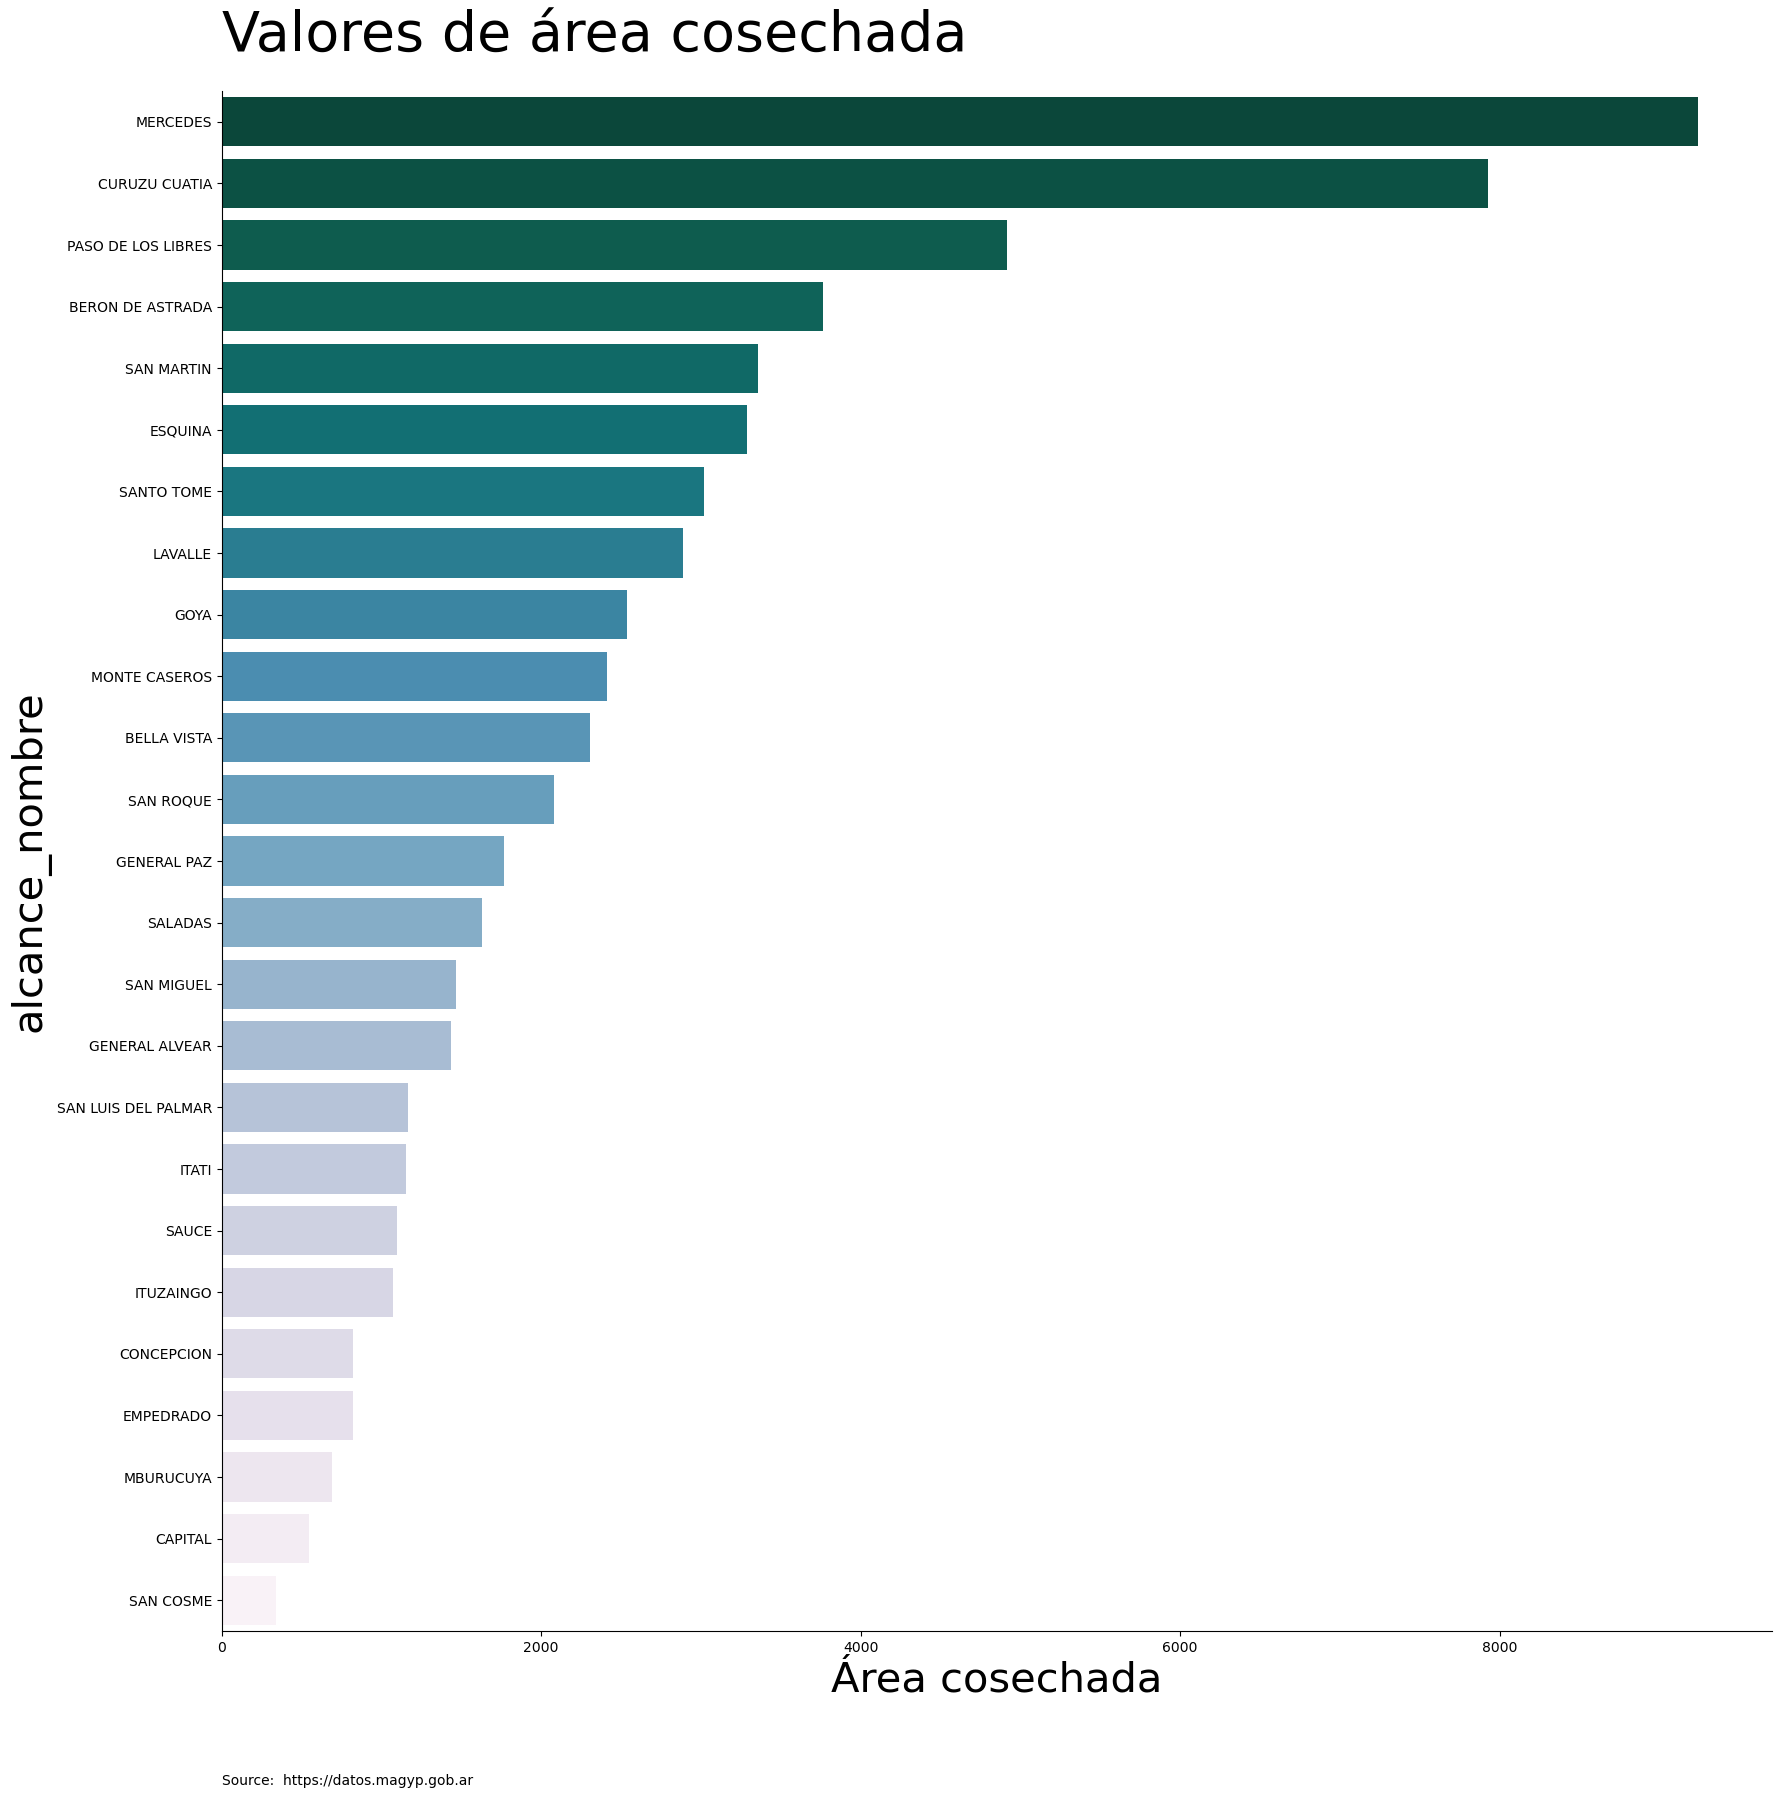

In [18]:
#estructurar datos
Corrientes_pivot = pd.pivot_table(df1, index = ["alcance_nombre"], columns=["indice_tiempo"], values = ["valor"])
Corrientes_pivot["Área cosechada"] = Corrientes_pivot.mean(axis=1)
Corrientes_pivot.reset_index(inplace = True)

#Construir visualización 
plt.figure(figsize= (20,20))
sns.barplot(y = "alcance_nombre", x = "Área cosechada", data =Corrientes_pivot, 
            palette = "PuBuGn_r", order =Corrientes_pivot.sort_values("Área cosechada", ascending = False)["alcance_nombre"])

#detalles
plt.ylabel("alcance_nombre", fontsize=30)
plt.xlabel("Área cosechada", fontsize=30)

plt.title("Valores de área cosechada", 
          fontsize = 40, loc='left', y = 1.02)
plt.annotate('Source:  https://datos.magyp.gob.ar', (0,-.1), xycoords ='axes fraction' )
sns.despine(top = True, right = True, left = False, bottom = False)

In [19]:
df1['indice_tiempo'].unique()

array(['1/1/1970', '1/1/1971', '1/1/1972', '1/1/1973', '1/1/1974',
       '1/1/1975', '1/1/1976', '1/1/1977', '1/1/1978', '1/1/1979',
       '1/1/1980', '1/1/1981', '1/1/1982', '1/1/1983', '1/1/1984',
       '1/1/1985', '1/1/1986', '1/1/1987', '1/1/1990', '1/1/1991',
       '1/1/1992', '1/1/1993', '1/1/1994', '1/1/1995', '1/1/1996',
       '1/1/1997', '1/1/1998', '1/1/1999', '1/1/2000', '1/1/2001',
       '1/1/2002', '1/1/2003', '1/1/2004', '1/1/2005', '1/1/2006',
       '1/1/2007', '1/1/2008', '1/1/2009', '1/1/2010', '1/1/2011',
       '1/1/2019', '1/1/2020', '1/1/2021', '1/1/2022', '1/1/2023'],
      dtype=object)

### Filtro de última cosecha  por Ha en 2023 por Departamento

In [57]:

en_2023 = df1['indice_tiempo'] == '1/1/2023'
en_2023.head()

0    False
1    False
2    False
3    False
4    False
Name: indice_tiempo, dtype: bool

In [58]:
cosecha_2023 = df1[en_2023]
cosecha_2023.head(11)

,sector_id,sector_nombre,variable_id,actividad_producto_nombre,indicador,unidad_de_medida,fuente,frecuencia_nombre,cobertura_nombre,alcance_tipo,alcance_id,alcance_nombre,indice_tiempo,valor
44,33,Arroz,910,Arroz,Area Cosechada,ha,MAGYP,Anual,Nacional,DEPARTAMENTO,18007,BELLA VISTA,1/1/2023,1400
88,33,Arroz,910,Arroz,Area Cosechada,ha,MAGYP,Anual,Nacional,DEPARTAMENTO,18014,BERON DE ASTRADA,1/1/2023,12100
191,33,Arroz,910,Arroz,Area Cosechada,ha,MAGYP,Anual,Nacional,DEPARTAMENTO,18035,CURUZU CUATIA,1/1/2023,10350
232,33,Arroz,910,Arroz,Area Cosechada,ha,MAGYP,Anual,Nacional,DEPARTAMENTO,18042,EMPEDRADO,1/1/2023,660
276,33,Arroz,910,Arroz,Area Cosechada,ha,MAGYP,Anual,Nacional,DEPARTAMENTO,18049,ESQUINA,1/1/2023,2300
319,33,Arroz,910,Arroz,Area Cosechada,ha,MAGYP,Anual,Nacional,DEPARTAMENTO,18056,GENERAL ALVEAR,1/1/2023,550
363,33,Arroz,910,Arroz,Area Cosechada,ha,MAGYP,Anual,Nacional,DEPARTAMENTO,18063,GENERAL PAZ,1/1/2023,550
407,33,Arroz,910,Arroz,Area Cosechada,ha,MAGYP,Anual,Nacional,DEPARTAMENTO,18070,GOYA,1/1/2023,6040
450,33,Arroz,910,Arroz,Area Cosechada,ha,MAGYP,Anual,Nacional,DEPARTAMENTO,18077,ITATI,1/1/2023,350
533,33,Arroz,910,Arroz,Area Cosechada,ha,MAGYP,Anual,Nacional,DEPARTAMENTO,18091,LAVALLE,1/1/2023,3300


### Cosecha de mayor valor

In [22]:
cosecha_2023.loc[(cosecha_2023["valor"]==cosecha_2023["valor"].max()),:]

,sector_id,sector_nombre,variable_id,actividad_producto_nombre,indicador,unidad_de_medida,fuente,frecuencia_nombre,cobertura_nombre,alcance_tipo,alcance_id,alcance_nombre,indice_tiempo,valor
606,33,Arroz,910,Arroz,Area Cosechada,ha,MAGYP,Anual,Nacional,DEPARTAMENTO,18105,MERCEDES,1/1/2023,16950


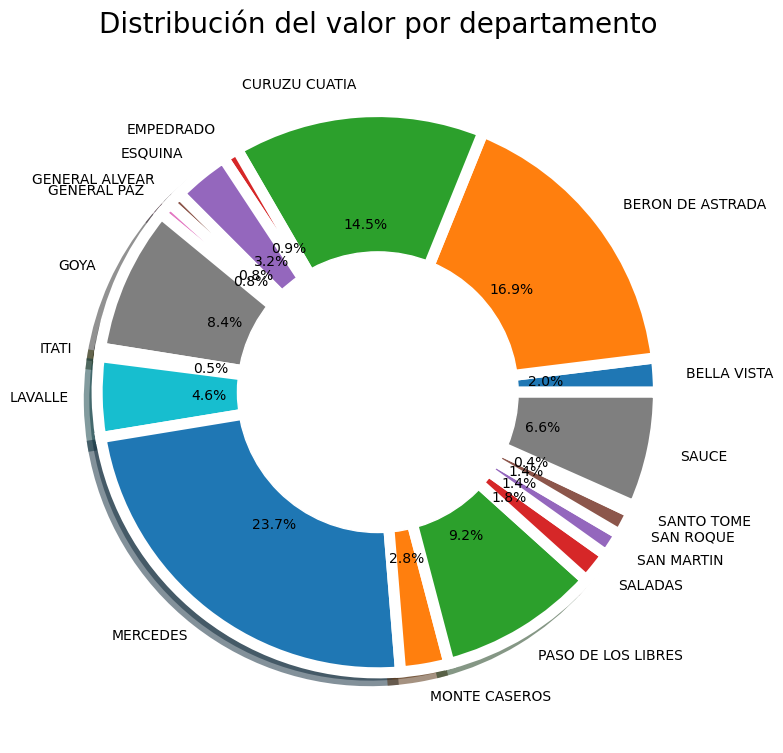

In [59]:
#definir datos
data = cosecha_2023['valor']
labels = cosecha_2023['alcance_nombre']

plt.figure(figsize=(8,8))
# Creando Donut Chart
plt.pie(data,labels=labels,wedgeprops = { 'linewidth' : 8, 'edgecolor' : 'white' },autopct='%2.1f%%',shadow=True)
plt.rc("font",size=10)
# Agregando un círculo en el centro
my_circle=plt.Circle( (0,0), 0.5, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title("Distribución del valor por departamento",size=20,loc="center")

plt.tight_layout()

## Departamento de Mercedes

### Filtro departamento de Mercedes  por Ha en 2023 por Departamento

In [60]:

en_mercedes = df1['alcance_nombre'] == 'MERCEDES'
en_mercedes.head()

0    False
1    False
2    False
3    False
4    False
Name: alcance_nombre, dtype: bool

In [61]:
mercedes = df1[en_mercedes]
mercedes.head()

,sector_id,sector_nombre,variable_id,actividad_producto_nombre,indicador,unidad_de_medida,fuente,frecuencia_nombre,cobertura_nombre,alcance_tipo,alcance_id,alcance_nombre,indice_tiempo,valor
563,33,Arroz,910,Arroz,Area Cosechada,ha,MAGYP,Anual,Nacional,DEPARTAMENTO,18105,MERCEDES,1/1/1970,380
564,33,Arroz,910,Arroz,Area Cosechada,ha,MAGYP,Anual,Nacional,DEPARTAMENTO,18105,MERCEDES,1/1/1971,245
565,33,Arroz,910,Arroz,Area Cosechada,ha,MAGYP,Anual,Nacional,DEPARTAMENTO,18105,MERCEDES,1/1/1972,360
566,33,Arroz,910,Arroz,Area Cosechada,ha,MAGYP,Anual,Nacional,DEPARTAMENTO,18105,MERCEDES,1/1/1973,720
567,33,Arroz,910,Arroz,Area Cosechada,ha,MAGYP,Anual,Nacional,DEPARTAMENTO,18105,MERCEDES,1/1/1974,845


## Mayores  Valores por Área Cosechada en Ha

In [26]:

mercedes.loc[(mercedes["valor"]==mercedes["valor"].max()),:]

,sector_id,sector_nombre,variable_id,actividad_producto_nombre,indicador,unidad_de_medida,fuente,frecuencia_nombre,cobertura_nombre,alcance_tipo,alcance_id,alcance_nombre,indice_tiempo,valor
603,33,Arroz,910,Arroz,Area Cosechada,ha,MAGYP,Anual,Nacional,DEPARTAMENTO,18105,MERCEDES,1/1/2020,23600
604,33,Arroz,910,Arroz,Area Cosechada,ha,MAGYP,Anual,Nacional,DEPARTAMENTO,18105,MERCEDES,1/1/2021,23600


### Gráfico de valor por área cosechada por año

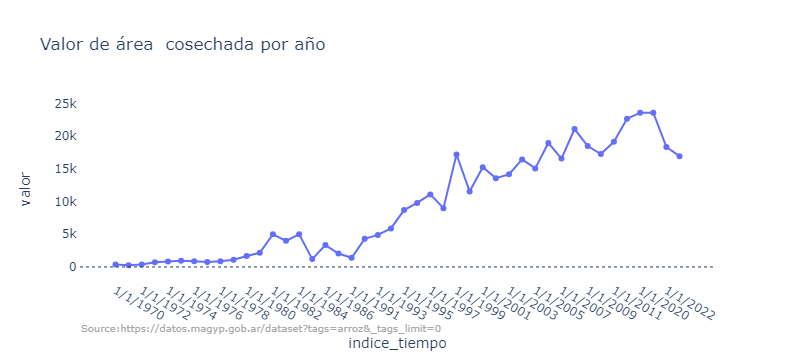

In [62]:

Valores = mercedes.groupby("indice_tiempo")["valor"].mean().reset_index()

fig = px.line(Valores, x="indice_tiempo", y = "valor", markers=True,  title = "Valor de área  cosechada por año")

fig.add_hline(0, line_width = 1, line_dash = "dot")

fig.update_layout({
'plot_bgcolor': 'white',
'paper_bgcolor': 'white',
})
fig.update_xaxes(showline=True, linewidth=1, linecolor='white')
fig.update_yaxes(showline=True, linewidth=1, linecolor='white')

fig.add_annotation(
    text = ("Source:https://datos.magyp.gob.ar/dataset?tags=arroz&_tags_limit=0"), showarrow=False, x = 0, y = -0.30
    , xref='paper', yref='paper', xanchor='left', yanchor='bottom', xshift=-1, yshift=-5
    , font=dict(size=10, color="darkgrey"), align="left")

fig.show()

## Análisis de datos del cultivo de arroz de exportación.

In [36]:
df_cultivos = pd.read_csv("datos-magyp-cultivos-principales.csv", 
                          sep=";", encoding="latin1", thousands=".", decimal=",")
df_cultivos.head()

,Cultivo,Campaña,Provincia,Departamento,Sup. Sembrada,Sup. Cosechada,Produccion,Rendimiento
0,Girasol,1969/70,BUENOS AIRES,25 de Mayo,30000,30000,22500,750
1,Girasol,1970/71,BUENOS AIRES,25 de Mayo,44000,31000,15000,484
2,Girasol,1971/72,BUENOS AIRES,25 de Mayo,22000,19000,10450,550
3,Girasol,1972/73,BUENOS AIRES,25 de Mayo,20000,5000,5100,1020
4,Girasol,1973/74,BUENOS AIRES,25 de Mayo,14000,14000,10800,771


## Precio internacional del cultivo

In [37]:
API_COMTRADE = "http://comtrade.un.org/api/get"

In [38]:
parametros = {
    "freq": "A", # frecuencia anual
    "r": 32, # reporter (reporta los datos): 32 es el código de la Argentina
    "ps": "ALL", # período (any para tomar todos los años)
    "px": "S1", # sistema de clasificación de productos: SITC Rev 1 es la serie más larga
    "fmt": "JSON", # formato devuelto (CSV o JSON)
    "p": 0, # partner (contraparte comercial del reporter): 0 es el código del Mundo
    "rg": 2, # 1: importaciones, 2: exportaciones
    "cc": "2214,041", # commodity code: 2214 "Arroz" 
    "max": 50000, # cantidad máxima de resultados (50.000 es un máximo absoluto)
    "head": "H", # M: machine readable headers, H: human readable headers
}

In [40]:

with open("comtrade-cultivos-principales.json", "rb") as f:
    json_res = json.load(f)

### Se crea un dataframe

In [41]:
arroz_precio = pd.DataFrame(json_res["dataset"])

### columnas a utilizar

In [42]:
columnas = ["rgDesc", "rtTitle", "ptTitle", "yr",
           "cmdCode", "cmdDescE", "TradeValue", "TradeQuantity", "qtDesc"]

In [43]:
arroz_precio[columnas].head(5)

,rgDesc,rtTitle,ptTitle,yr,cmdCode,cmdDescE,TradeValue,TradeQuantity,qtDesc
0,Export,Argentina,World,1962,041,"Wheat including spelt and meslin, unmilled",173363088,2832336128,Weight in kilograms
1,Export,Argentina,World,1963,041,"Wheat including spelt and meslin, unmilled",116388784,1830655616,Weight in kilograms
2,Export,Argentina,World,1964,041,"Wheat including spelt and meslin, unmilled",242256288,3710008576,Weight in kilograms
3,Export,Argentina,World,1965,041,"Wheat including spelt and meslin, unmilled",372666400,6660583936,Weight in kilograms
4,Export,Argentina,World,1966,041,"Wheat including spelt and meslin, unmilled",279624704,5054666240,Weight in kilograms


In [44]:
arroz_precio["tnPrec"] = arroz_precio.TradeValue / arroz_precio.TradeQuantity * 1000

In [45]:
precios_arroz = arroz_precio[arroz_precio.cmdCode == "2214"][["yr", "tnPrec"]].sort_values("yr").set_index("yr")


<Axes: xlabel='yr'>

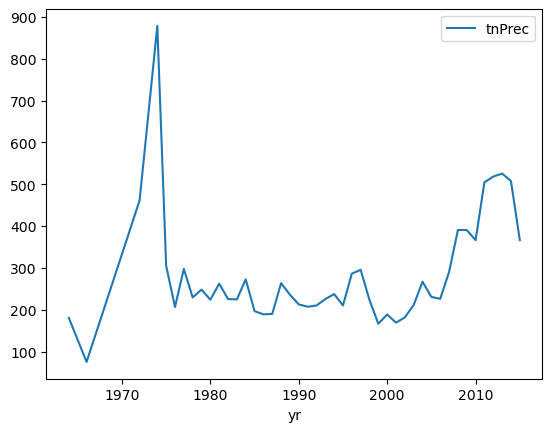

In [46]:
precios_arroz.plot.line()